In [51]:
# --- Cell 1: imports & user controls ---

from astroquery.mast import Catalogs
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

# ===== User controls =====
KOI_CSV   = "Kepler Objects of Interest.csv"  # path to your KOI table
N_TARGETS = 1                                  # <-- how many KOIs to process
EXPTIME   = 1800                               # preferred cadence in seconds (falls back if none)
DO_PLOTS  = True                               # set False to skip plotting
POINTSIZE = 2                                  # scatter point size
ALPHA     = 0.5                                # transparency for plots
SAVE_SUMMARY = False                           # set True to write a CSV of the summary
SUMMARY_CSV  = "koi_summary.csv"               # output path if saving


In [64]:
# --- Cell 2: helper functions ---

def fetch_lightcurve(kepid: int, exptime: int | None = None):
    """Search, download (all), and stitch a Kepler light curve for a given KIC."""
    q = f"KIC {kepid}"
    search = lk.search_lightcurve(q, mission="Kepler", exptime=exptime) if exptime else lk.search_lightcurve(q, mission="Kepler")
    if len(search) == 0 and exptime is not None:
        # fall back if that cadence isn't available
        search = lk.search_lightcurve(q, mission="Kepler")
    if len(search) == 0:
        raise RuntimeError(f"No Kepler light curves found for {q}")
    dl = search.download_all()  # LightCurveCollection or LightCurve
    lc = dl.stitch() if hasattr(dl, "stitch") else dl
    return lc

# --- NEW helper: normalize any 1D array to [-1, 1] ---
def normalize_to_unit_symmetric(x, *, clip_percentile=None):
    """
    Normalize array to [-1, 1] centered on 0.
    If clip_percentile is set (e.g., 0.5), it clips extremes before scaling for robustness.
    """
    x = np.asarray(x, dtype=float)

    if clip_percentile is not None:
        lo = np.nanpercentile(x, clip_percentile)
        hi = np.nanpercentile(x, 100 - clip_percentile)
        m = (x >= lo) & (x <= hi) & np.isfinite(x)
        scale = np.nanmax(np.abs(x[m])) if np.any(m) else np.nanmax(np.abs(x))
    else:
        scale = np.nanmax(np.abs(x))

    if not np.isfinite(scale) or scale == 0:
        return np.zeros_like(x)

    return x / scale  # now in [-1, 1]

# --- UPDATED: prepare_flux_time now returns time and flux in [-1, 1] ---
def prepare_flux_time(lc):
    """
    Return time (BKJD) and flux normalized to [-1, 1].
    Uses PDCSAP if available. Robust to version differences.
    """
    tbl = lc.to_table()
    colnames = set(tbl.colnames)

    # pick flux column
    if "pdcsap_flux" in colnames:
        raw_flux = tbl["pdcsap_flux"].astype(float)
    elif "flux" in colnames:
        raw_flux = tbl["flux"].astype(float)
    else:
        raise RuntimeError(f"No suitable flux column found. Available: {sorted(colnames)}")

    if "time" not in colnames:
        raise RuntimeError(f"No 'time' column found. Available: {sorted(colnames)}")

    time = tbl["time"].value.astype(float)
    flux = np.asarray(raw_flux, dtype=float)

    # finite mask
    m = np.isfinite(time) & np.isfinite(flux)
    time = time[m]
    flux = flux[m]

    # center on 0 by removing the median fractional baseline, then scale to [-1, 1]
    # 1) relative flux around 1
    med = np.nanmedian(flux)
    if not np.isfinite(med) or med == 0:
        raise RuntimeError("Median flux is non-finite or zero; cannot normalize.")
    rel = flux / med  # ~1 +/- small variations

    # 2) deviations around 0
    dev = rel - 1.0

    # 3) scale symmetrically to [-1, 1]
    dev_norm = normalize_to_unit_symmetric(dev, clip_percentile=0.5)  # adjust/disable clipping if you want

    # dev_norm is now in [-1, 1]
    return time, dev_norm

def flux_to_mmag(flux_norm: np.ndarray):
    """Convert normalized flux to mmag (mean-subtracted)."""
    # m = -2.5 * log10(F)
    mag = -2.5 * np.log10(flux_norm)
    mmag = (mag - np.nanmean(mag)) * 1000.0
    return mmag

def compute_phase(time_bkjd: np.ndarray, period_days: float, epoch_bkjd: float):
    """Compute orbital phase in [0,1)."""
    return ((time_bkjd - epoch_bkjd) / period_days) % 1.0

def process_one_koi(row: pd.Series, exptime: int | None, do_plot: bool, i: int | None = None):
    """End-to-end for a single KOI row: download, clean, mmag, phase, optional plot."""
    kepid  = int(row["kepid"])
    period = float(row["koi_period"])
    epoch  = float(row["koi_time0bk"])

    print(f"period, epoch = {period}, {epoch}")

    print(f"[{i}] KIC {kepid} | P={period:.6f} d | epoch (BKJD)={epoch:.6f}")

    lc = fetch_lightcurve(kepid, exptime=exptime)
    time, flux_norm = prepare_flux_time(lc)
    mmag  = flux_to_mmag(flux_norm)
    phase = compute_phase(time, period, epoch)

    if do_plot:
        plt.figure(figsize=(7,4))
        plt.scatter(phase, mmag, s=POINTSIZE, alpha=ALPHA)
        plt.gca().invert_yaxis()  # magnitudes: up = brighter
        plt.xlabel("Orbital Phase")
        plt.ylabel("Relative Brightness (mmag)")
        plt.title(f"KIC {kepid} — Phase-folded (P={period:.6f} d)")
        plt.show()

    return {
        "kepid": kepid,
        "koi_period_days": period,
        "koi_epoch_bkjd": epoch,
        "n_points": len(time),
        "mmag_mean": float(np.nanmean(mmag)),
        "mmag_std":  float(np.nanstd(mmag)),
        "mmag_ptp":  float(np.nanmax(mmag) - np.nanmin(mmag)),
    }


In [65]:
# --- Cell 3: load KOI table ---

df = pd.read_csv(KOI_CSV, comment="#")

print(f"Loaded {len(df)} KOIs from: {KOI_CSV}")
if N_TARGETS > len(df):
    print(f"Requested N_TARGETS={N_TARGETS} but table has only {len(df)} rows; processing all.")
    N_TARGETS = len(df)

# Peek at the first few rows (optional)
display(df.head(3)[["kepid","koi_period","koi_time0bk"]])


Loaded 9564 KOIs from: Kepler Objects of Interest.csv


,kepid,koi_period,koi_time0bk
0,10797460,9.488036,170.538750
1,10797460,54.418383,162.513840
2,10811496,19.899140,175.850252


period, epoch = 9.48803557, 170.53875
[0] KIC 10797460 | P=9.488036 d | epoch (BKJD)=170.538750


/var/folders/lb/kms47w652232qtwkxqftr9n40000gn/T/ipykernel_67954/3842307673.py:84: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux_norm)


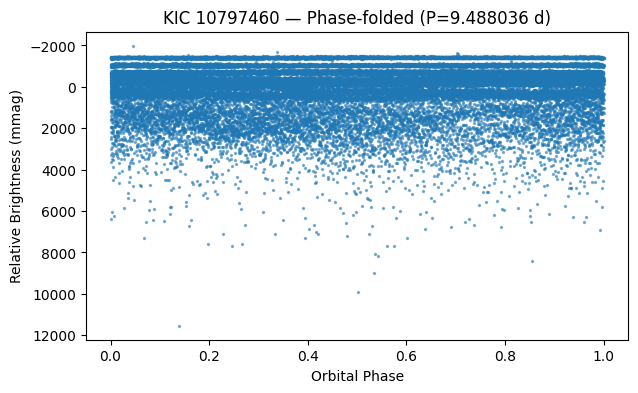

Finished. Summary rows: 1


In [66]:
# --- Cell 4: run the batch ---

results = []
for i in range(N_TARGETS):
    try:
        out = process_one_koi(df.iloc[i], exptime=EXPTIME, do_plot=DO_PLOTS, i=i)
        results.append(out)
    except Exception as e:
        print(f"!! Skipped index {i} ({df.iloc[i]['kepid']}): {e}")

summary = pd.DataFrame(results)
print("Finished. Summary rows:", len(summary))


In [67]:
# --- Cell 5: inspect & save summary ---

display(summary)

if SAVE_SUMMARY:
    summary.to_csv(SUMMARY_CSV, index=False)
    print(f"Summary written to: {SUMMARY_CSV}")


,kepid,koi_period_days,koi_epoch_bkjd,n_points,mmag_mean,mmag_std,mmag_ptp
0,10797460,9.488036,170.53875,64814,5.747663e-14,1252.526084,13526.399024
